## 224 x 224 version ##


In [1]:
## import dependencies
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR


In [3]:
# create and print the categories list from directory
test_dir = '../category_train'
categories = os.listdir(test_dir)
print(categories)

['0-T-shirt', '1-TrouserJeans', '2-Pullover', '3-Dress', '4-CoatJacket', '5-Sandal', '6-Shirt', '7-Shoes', '8-Bag', '9-Ankle Boot']


# Prepare the data

In [4]:
# create a transform function to convert any images given into 224x224 images

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                                transforms.Normalize((0.5,), (0.5,))])

# download the MNIST training data
train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)



100%|██████████| 26421880/26421880 [00:01<00:00, 16375863.59it/s]


Extracting F_MNIST_data\FashionMNIST\raw\train-images-idx3-ubyte.gz to F_MNIST_data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 275589.68it/s]


Extracting F_MNIST_data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to F_MNIST_data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4645197.06it/s]


Extracting F_MNIST_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to F_MNIST_data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]


Extracting F_MNIST_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to F_MNIST_data\FashionMNIST\raw



In [6]:
# split train set into training (80%) and validation set (20%)

train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

In [7]:
# prepare dataloaders; this step converts our images that were imported into pytorch tensors

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)


torch.Size([1, 224, 224]) torch.Size([64])
3-Dress


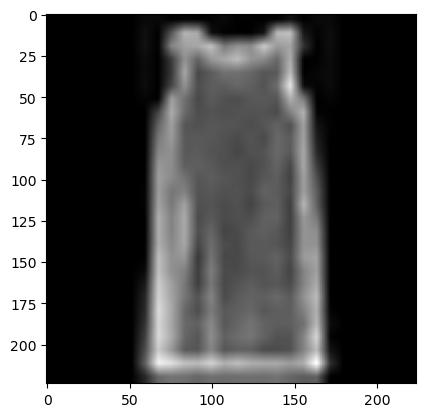

In [8]:
# print image to see if it worked

image, label = next(iter(train_dl))
print(image[0].shape, label.shape) # print the shape of the (1 channel, height, width)
desc = categories
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

In [9]:
# model function

def network():
    model = nn.Sequential(OrderedDict([
        ('flatten', nn.Flatten()),  # Flatten the input image (move this to the beginning)
        ('fc1', nn.Linear(50176, 512)),  # Adjust the input size
        ('relu1', nn.ReLU()),
        ('drop1', nn.Dropout(0.25)),
        ('fc2', nn.Linear(512, 256)),
        ('relu2', nn.ReLU()),
        ('drop2', nn.Dropout(0.25)),
        ('output', nn.Linear(256, 10)),
        ('logsoftmax', nn.LogSoftmax(dim=1))
    ]))

    device = 'cuda' if torch.cuda.is_available() else 'cpu' # pytorch can use cuda cores or cpu
    model = model.to(device)

    # define the criterion and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    return model, loss_fn, optimizer, device                      

In [10]:
from torchsummary import summary

model, loss_fn, optimizer, device = network()

# print summary
summary(model, (1, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 50176]               0
            Linear-2                  [-1, 512]      25,690,624
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
        LogSoftmax-9                   [-1, 10]               0
Total params: 25,824,522
Trainable params: 25,824,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.40
Params size (MB): 98.51
Estimated Total Size (MB): 99.10
-----------------------------------

In [11]:
# label my folders
# this step is important because that is the crux of CNN: labelling
num_labels = len(categories)

category_to_label = {
    colour: idx for idx, colour in enumerate(categories)
}

label_to_category = {
    idx: colour for idx, colour in enumerate(categories)
}

print(num_labels)
print(category_to_label)
print(label_to_category)


10
{'0-T-shirt': 0, '1-TrouserJeans': 1, '2-Pullover': 2, '3-Dress': 3, '4-CoatJacket': 4, '5-Sandal': 5, '6-Shirt': 6, '7-Shoes': 7, '8-Bag': 8, '9-Ankle Boot': 9}
{0: '0-T-shirt', 1: '1-TrouserJeans', 2: '2-Pullover', 3: '3-Dress', 4: '4-CoatJacket', 5: '5-Sandal', 6: '6-Shirt', 7: '7-Shoes', 8: '8-Bag', 9: '9-Ankle Boot'}


In [12]:
## create a class so that it loads an image I give it

from PIL import ImageOps

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((224, 224)), # resize it to a square of 28x28
                transforms.Grayscale(num_output_channels=1),  # Convert to black and white
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485], std=[0.229]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('L') # open image and convert to grayscale
        inverted_img = ImageOps.invert(img)  # Invert the colours
        t_img = self.transform(inverted_img) # transform the image defined above
        return t_img


In [15]:
## grab the images from my local directories

class ImageDataset(Dataset):

    train_data_dir = '../category_train'

    def __init__ (self, image_loader):
        categories = os.listdir(self.train_data_dir)

        self.data = []

        for category in tqdm(categories):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{category}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{category}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = category_to_label[category]
                self.data.append((t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [16]:
## create the dataset

dataset = ImageDataset(ImageLoader()) # my own images

100%|██████████| 10/10 [00:00<00:00, 20.53it/s]


In [17]:
## split the dataset

val_ratio = 0.2 # testing ratio 20%
test_size = 10 # I chose 10 for now because I only have 1-2 images from each folder

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest


In [18]:
## convert my test_dataset into tensors

test_dl = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [19]:
## this function is for making y axis percent
from matplotlib.ticker import FuncFormatter


def percent_formatter(x, pos):
    return f'{x*100:.2f}%'

In [20]:
## plotting function once the model is complete

# losses are not a percentage

def plot_losses(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(1, epochs + 1), train_metric)
    plt.plot(range(1, epochs + 1), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(1, epochs + 1))  # Use range for the positions of ticks
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)

    plt.grid(True)
    plt.show()


## plotting accuracies once the model is complete
# a separate function was created so I can add percentages to the y axis

def plot_accuracy(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(1, epochs + 1), train_metric)
    plt.plot(range(1, epochs + 1), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(1, epochs + 1))  # Use range for the positions of ticks
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)

    # Use percent_formatter for y-axis ticks
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    plt.grid(True)
    plt.show()



# Train the model

In [21]:
######################
# train/ model function
######################

import time

# defined only 5 epochs because there wasn't a significant increase in accuracy after 5 epochs
# each epoch is 2-3 minutes so I limited to only 5 epochs for now

def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=10):
    train_losses, test_losses = [], []
    train_acc_list, test_acc_list = [], []
    start_time = time.time()  # Record the start time for the epoch
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_loss = 0
        train_acc = 0  # Initialize train_epoch_acc here

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # flatten the images to batch_size
            images = images.view(images.shape[0], -1)
            # forward pass
            outputs = model(images)
            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            # Weight updates
            optimizer.step()
            train_loss += train_batch_loss.item()

            # Calculate training accuracy
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions = (predicted_labels == labels).sum().item()
            total_samples = labels.size(0)
            train_batch_acc = correct_predictions / total_samples
            
            train_loss += train_batch_loss.item()
            train_acc += train_batch_acc
            
        else:
            # One epoch of training complete
            # calculate average training epoch loss
            train_loss = train_loss/len(trainloader)

            # Now Validate on testset
            with torch.no_grad():
                test_acc = 0
                test_loss = 0
                # Set mode to eval - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)                    
                    # flatten images to batch_size
                    images = images.view(images.shape[0], -1)
                    # make predictions 
                    test_outputs = model(images)
                    # calculate test loss
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_loss += test_batch_loss
                    
                    # get probabilities, extract the class associated with highest probability
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    
                    # compare actual labels and predicted labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_acc += batch_acc.item()
                else:
                    # One epoch of training and validation done
                    # calculate average testing epoch loss
                    test_loss = test_loss/len(testloader)
                    # calculate accuracy as correct_pred/total_samples
                    test_acc = test_acc/len(testloader)
                    train_acc = train_acc / len(trainloader)
                    # save epoch losses for plotting
                    train_losses.append(train_loss)
                    test_losses.append(test_loss)
                    train_acc_list.append(train_acc)
                    test_acc_list.append(test_acc)

                    # print stats for this epoch
                    print(f'Epoch: {epoch+1} -> train_loss: {train_loss:.2f}, val_loss: {test_loss:.2f}, ',
                          f'train_acc: {train_acc*100:.2f}%, val_acc: {test_acc*100:.2f}%')


    # plot losses
    plot_losses(n_epochs, train_losses, test_losses, 'loss', 'Losses', 'Losses over Epochs')    

    # plot accuracies
    plot_accuracy(n_epochs, train_acc_list, test_acc_list, 'accuracy', 'Accuracy (%)', 'Accuracy over Epochs')

    
    end_time = time.time()  # Record the end time for the epoch
    elapsed_time = end_time - start_time  # Calculate the elapsed time   
    minutes = int(elapsed_time//60.0)
    seconds = elapsed_time % 60

    print(f'Model Runtime: {minutes} minutes {seconds:.2f}seconds') 
                


Epoch: 1 -> train_loss: 1.52, val_loss: 0.49,  train_acc: 74.84%, val_acc: 82.31%
Epoch: 2 -> train_loss: 1.11, val_loss: 0.47,  train_acc: 80.06%, val_acc: 83.21%
Epoch: 3 -> train_loss: 1.04, val_loss: 0.44,  train_acc: 81.59%, val_acc: 83.65%
Epoch: 4 -> train_loss: 1.02, val_loss: 0.43,  train_acc: 82.02%, val_acc: 83.96%
Epoch: 5 -> train_loss: 1.00, val_loss: 0.43,  train_acc: 82.23%, val_acc: 85.18%
Epoch: 6 -> train_loss: 0.99, val_loss: 0.41,  train_acc: 82.64%, val_acc: 85.14%
Epoch: 7 -> train_loss: 0.98, val_loss: 0.43,  train_acc: 82.71%, val_acc: 84.01%
Epoch: 8 -> train_loss: 0.97, val_loss: 0.43,  train_acc: 82.98%, val_acc: 84.62%
Epoch: 9 -> train_loss: 0.96, val_loss: 0.41,  train_acc: 83.15%, val_acc: 85.32%
Epoch: 10 -> train_loss: 0.94, val_loss: 0.42,  train_acc: 83.71%, val_acc: 85.29%


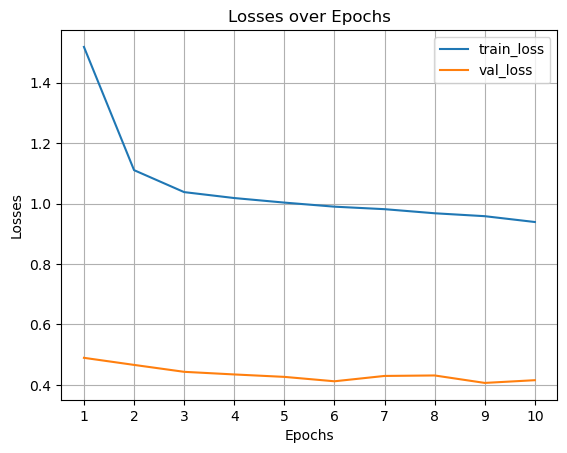

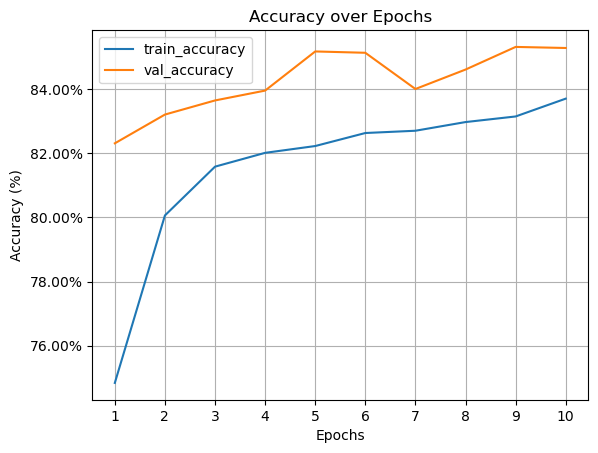

Model Runtime: 23 minutes 54.04seconds


In [22]:
## Run the model

train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

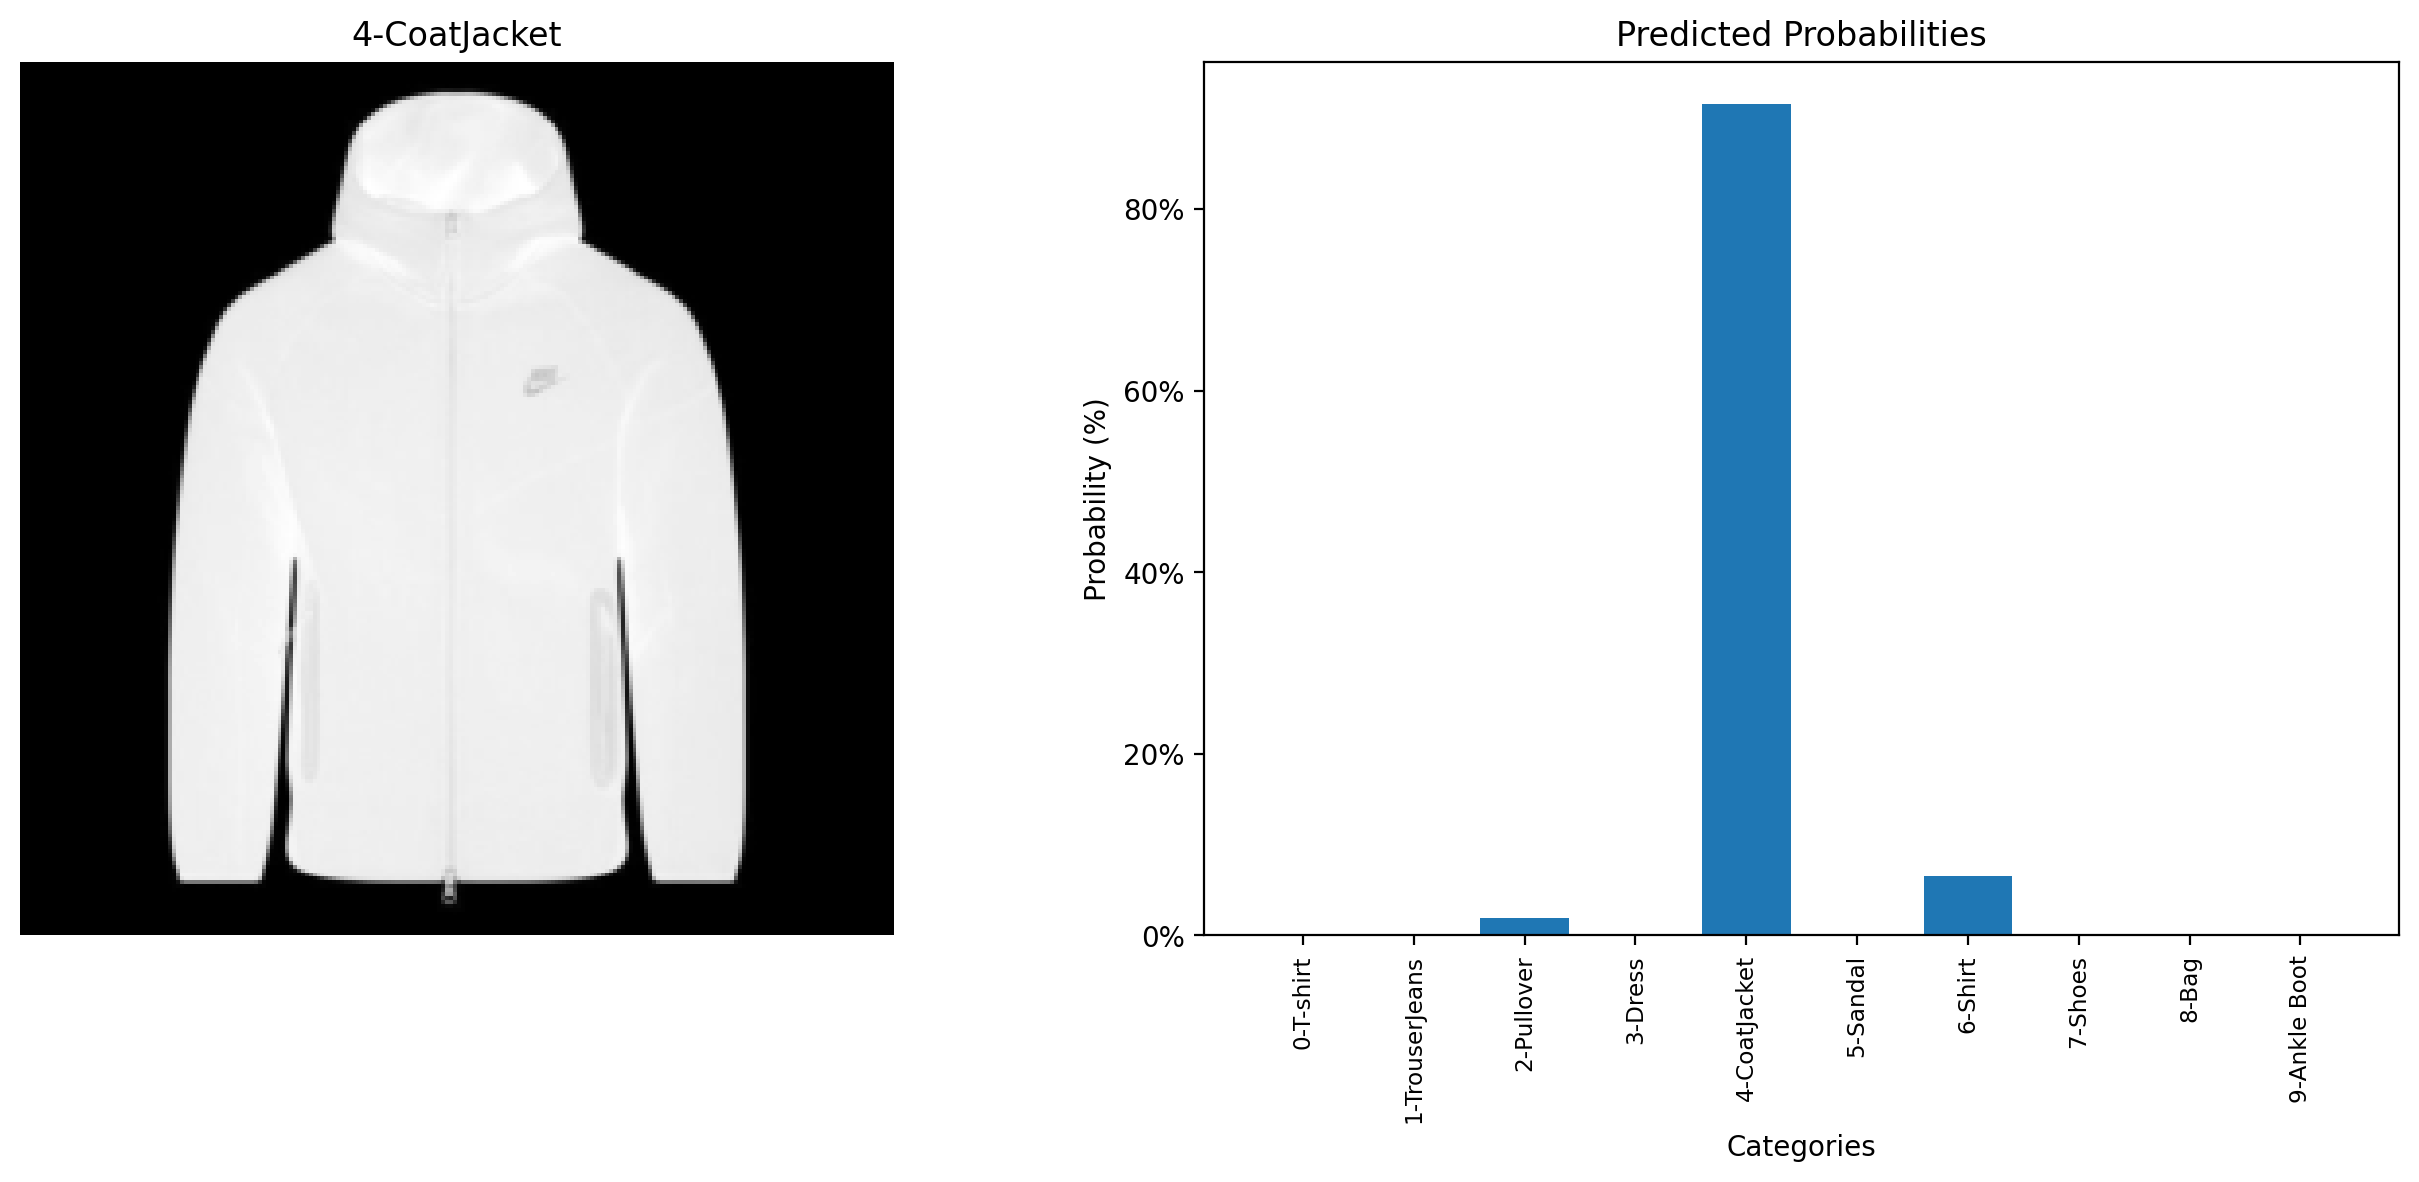

The model predicts it is a 4-CoatJacket with a probability of 91.58% certainty


In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.ticker import FuncFormatter

# Function to format y-axis ticks as percentages with 0 decimal places
def percent_formatter(x, pos):
    return f'{x*100:.0f}%'

# Assuming test_dl is a DataLoader object
for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    index = 4
    img, label = images[index], labels[index]
    
    # Convert 2D image to 1D vector
    img = img.view(img.shape[0], -1)

    # Calculate the class probabilities (softmax) for img
    proba = torch.exp(model(img))

    # Plot the image and probabilities
    desc = categories
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
    ax1.axis('off')
    ax1.imshow(images[index].cpu().numpy().squeeze(), cmap='gray')  # Specify 'gray' colormap
    ax1.set_title(desc[label.item()])
    ax2.bar(range(10), proba.detach().cpu().numpy().squeeze(), align='center')
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(desc, size='small', rotation='vertical')

    # Use percent_formatter for y-axis ticks
    ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    ax2.set_xlabel('Categories')
    ax2.set_ylabel('Probability (%)')
    ax2.set_title('Predicted Probabilities')
    plt.tight_layout()
    plt.show()
    max_value = max(proba.detach().cpu().numpy().squeeze())
    max_index = np.argmax(proba.detach().cpu().numpy().squeeze())

    print(f'The model predicts it is a {categories[max_index]} with a probability of {max_value*100:.2f}% certainty')

    break  # Break the loop after processing one batch if you just want to visualize one example
